## MSA vs PSP, New Excel SHeet, Age, Sex, and UPDRS only

From request [Run MSA v PSP with 1002 Excel sheet for only UPDRS sex and age](https://trello.com/c/t38U3cTW)

New Data Sheet.  MSA vs PSP and PSP vs MSA. Only Age, Sex, UPDRS


## Imports and Function Definitions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [2]:
param_grid = {
    "classifier__C": np.logspace(-5, 2, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.2
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score)
}
_scoring='f1_micro'
_data = pd.read_excel('1002_Data_no_Subj_Site.xlsx')
_data = _data[['GroupID', 'Age', 'Sex', 'UPDRS']]
_random_seed = 55

## 5. PSP (positive) vs MSA (negative)

In [3]:
# Get the data
data4 = group_classes(_data, {2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s


Best parameters set found on development set:

{'classifier__C': 0.048329302385717518}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.31      0.38      0.34        13
        1.0       0.70      0.63      0.67        30

avg / total       0.59      0.56      0.57        43


recall	0.633333333333
precision	0.703703703704
auc	0.508974358974
specificity	0.384615384615
npv	0.3125
accuracy	0.558139534884


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.1s finished


In [4]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.00340008735657	0.000969426630611
score_time	0.00390095710754	0.000799980811264
test_recall	0.667894736842	0.105215778811
train_recall	0.676803797468	0.0228873396369
test_precision	0.781764507422	0.0957109683723
train_precision	0.782399129074	0.0346019059782
test_auc	0.699661654135	0.0901241911717
train_auc	0.706290369912	0.0301353128205
test_specificity	0.731428571429	0.124343172269
train_specificity	0.735776942356	0.0491779203385
test_npv	0.616666666667	0.104436724759
train_npv	0.619871740064	0.0277935226111
test_accuracy	0.693868092692	0.0887190398129
train_accuracy	0.701463591114	0.0277940644804


In [5]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	0.591455905622
Sex	0.187634738115
UPDRS	-0.662217319372


             precision    recall  f1-score   support

        0.0       0.31      0.38      0.34        13
        1.0       0.70      0.63      0.67        30

avg / total       0.59      0.56      0.57        43



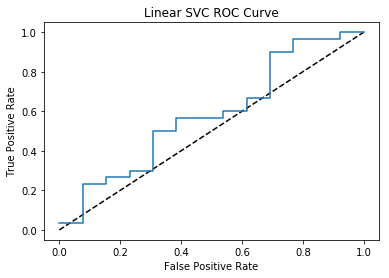

0.0 0.0333333333333
0.0769230769231 0.0333333333333
0.0769230769231 0.233333333333
0.153846153846 0.233333333333
0.153846153846 0.266666666667
0.230769230769 0.266666666667
0.230769230769 0.3
0.307692307692 0.3
0.307692307692 0.5
0.384615384615 0.5
0.384615384615 0.566666666667
0.538461538462 0.566666666667
0.538461538462 0.6
0.615384615385 0.6
0.615384615385 0.666666666667
0.692307692308 0.666666666667
0.692307692308 0.9
0.769230769231 0.9
0.769230769231 0.966666666667
0.923076923077 0.966666666667
0.923076923077 1.0
1.0 1.0


In [6]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)

## 6. MSA (positive) vs PSP (negative)

In [7]:
# Get the data
data4 = group_classes(_data, {2:1, 3:0})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    7.8s remaining:    1.3s


Best parameters set found on development set:

{'classifier__C': 0.048329302385717518}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.70      0.63      0.67        30
        1.0       0.31      0.38      0.34        13

avg / total       0.59      0.56      0.57        43


recall	0.384615384615
precision	0.3125
auc	0.508974358974
specificity	0.633333333333
npv	0.703703703704
accuracy	0.558139534884


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.1s finished


In [8]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.00410051345825	0.000915999581317
score_time	0.0050018787384	0.00104806120086
test_recall	0.731428571429	0.124343172269
train_recall	0.735776942356	0.0491779203385
test_precision	0.616666666667	0.104436724759
train_precision	0.619871740064	0.0277935226111
test_auc	0.699661654135	0.0901241911717
train_auc	0.706290369912	0.0301353128205
test_specificity	0.667894736842	0.105215778811
train_specificity	0.676803797468	0.0228873396369
test_npv	0.781764507422	0.0957109683723
train_npv	0.782399129074	0.0346019059782
test_accuracy	0.693868092692	0.0887190398129
train_accuracy	0.701463591114	0.0277940644804


In [9]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	-0.591393122754
Sex	-0.18840053372
UPDRS	0.661648238171


             precision    recall  f1-score   support

        0.0       0.70      0.63      0.67        30
        1.0       0.31      0.38      0.34        13

avg / total       0.59      0.56      0.57        43



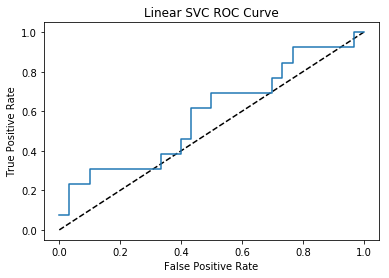

0.0 0.0769230769231
0.0333333333333 0.0769230769231
0.0333333333333 0.230769230769
0.1 0.230769230769
0.1 0.307692307692
0.333333333333 0.307692307692
0.333333333333 0.384615384615
0.4 0.384615384615
0.4 0.461538461538
0.433333333333 0.461538461538
0.433333333333 0.615384615385
0.5 0.615384615385
0.5 0.692307692308
0.7 0.692307692308
0.7 0.769230769231
0.733333333333 0.769230769231
0.733333333333 0.846153846154
0.766666666667 0.846153846154
0.766666666667 0.923076923077
0.966666666667 0.923076923077
0.966666666667 1.0
1.0 1.0


In [10]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)